In [2]:
from rerf.rerfClassifier import rerfClassifier
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten
from tensorflow.keras.optimizers import SGD, Adam
import time
import pickle

In [74]:
def test_s_rerf_3d():
    #blob0 = np.random.multivariate_normal([1,1,1], np.eye((3), 100).reshape(100,-1)
    #blob1 = np.random.multivariate_normal([-1,-1,-1], np.eye((3), 100).reshape(100,-1)
    #X = np.vstack((blob0,blob1))
    #Y = np.array([0]*100 + [1]*100).reshape(-1,1)
    mat = pd.read_csv("packedForest/res/cifar_01.csv", header=None).values        
    X = mat[:,1:].reshape(200,32,32,3)
    np.swapaxes(X, 1, -1)
    X = X.reshape(200,-1)
    Y = mat[:,0]

    clf = rerfClassifier(
        projection_matrix="MORF-3D", image_height=32, image_width=32, image_depth=3, n_estimators=50
    )
    clf.fit(X, Y)
    score = clf.score(X, Y)
    return score

# Test on MNIST (make sure I'm doing this right)

In [31]:
(x_train,y_train), (x_test,y_test) = mnist.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
x_train = x_train.flatten().reshape(60000,784)
x_test = x_test.flatten().reshape(10000,784)

#Reduce sample size
num_sample = 5000
x_train = x_train[:num_sample]
y_train = y_train[:num_sample]


In [32]:
scores_mnist = []
for i in range(1,7):
    
    clf = rerfClassifier(
        projection_matrix="MORF", image_height=28, image_width=28, image_depth=1, n_estimators=50, 
        patch_height_min = i, patch_height_max = i, patch_width_min = i, 
        patch_width_max = i)
    
    clf.fit(x_train,y_train)
    scores_mnist.append(clf.score(x_test,y_test))

Text(0, 0.5, 'Accuracy')

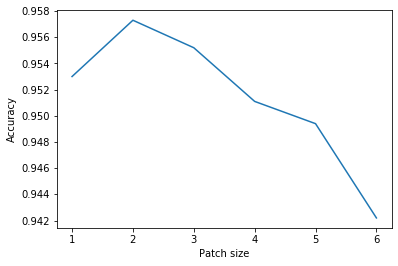

In [16]:

plt.plot(range(1,7), scores)
plt.xlabel('Patch size')
plt.ylabel('Accuracy')

In [78]:
predicts = clf.predict(x_test)
score = clf.score(x_test, y_test)
score

0.9479

3


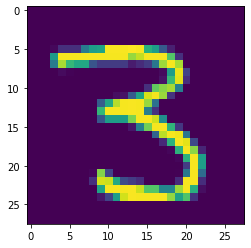

In [80]:
idx = np.random.randint(0,10000)
plt.imshow(x_test[idx].reshape(28,28))
print(predicts[idx])

# Test MORF-3d on CIFAR

In [35]:
(x_train,y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
x_train = x_train.flatten().reshape(50000,3072)
x_test = x_test.flatten().reshape(10000,3072)
y_train = y_train.reshape(50000,)
y_test = y_test.reshape(10000,)

#Reduce # of training samples
x_train, y_train = x_train[:5000], y_train[:5000] 
x_test, y_test = x_test[:1000], y_test[:1000]
x_train.shape

(5000, 3072)

In [37]:
scores_morf3d = []
for i in range(1,7):
    
    clf = rerfClassifier(
            projection_matrix="MORF-3D", image_height=32, image_width=32, image_depth=3, n_estimators=50, 
        patch_height_min = i, patch_height_max = i, patch_width_min = i, 
        patch_width_max = i)
    clf.fit(x_train,y_train)
    scores_morf3d.append(clf.score(x_test,y_test))


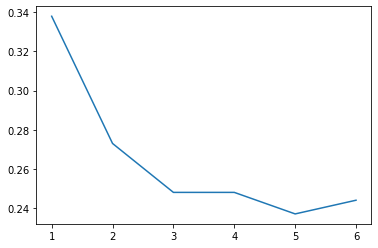

In [47]:
plt.plot(range(1,7), scores_morf3d)

In [84]:
predicts = clf.predict(x_test)

score = clf.score(x_test,y_test)
#pickle.dump(clf, open("morf-3d-cifar.sav", 'w'))
score

0.2312

In [62]:
labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
idx = np.random.randint(0,1000)
plt.imshow(x_test[idx].reshape(32,32,3))
print("Predict: " + labels[predicts[idx]])
print("Actual: " + labels[y_test[idx]])


IndexError: index 8742 is out of bounds for axis 0 with size 1000

# Try using 2D MORF on CIFAR

In [49]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.299, dtype=dtype), np.asarray(.587, dtype=dtype), np.asarray(.144, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

(x_train,y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train/255.0
x_test = x_test/255.0
y_train = y_train.reshape(50000,)
y_test = y_test.reshape(10000,)
#Limit # of samples
num_sample = 5000
x_train = x_train[:num_sample]
y_train = y_train[:num_sample]

x_test, y_test = x_test[:1000],y_test[:1000]
x_train, x_test = grayscale(x_train).reshape(num_sample, 1024), grayscale(x_test).reshape(1000,1024)

In [50]:
scores_morf2d = []
for i in range(1,7):
    
    clf = rerfClassifier(
            projection_matrix="MORF", image_height=32, image_width=32, image_depth=1, n_estimators=50, 
        patch_height_min = i, patch_height_max = i, patch_width_min = i, 
        patch_width_max = i)

    clf.fit(x_train,y_train)
    scores_morf2d.append(clf.score(x_test,y_test))

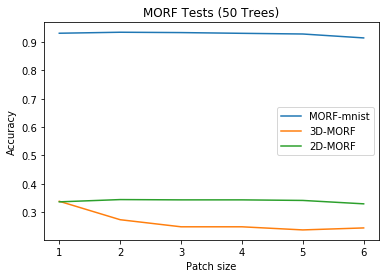

In [61]:
plt.plot(range(1,7), scores_mnist)
plt.plot(range(1,7), scores_morf3d)
plt.plot(range(1,7), scores_morf2d)
plt.xlabel('Patch size')
plt.ylabel("Accuracy")
plt.legend(["MORF-mnist","3D-MORF",'2D-MORF'])
plt.title("MORF Tests (50 Trees)")
plt.savefig("MORF_tests.png")

# Neural net for CIFAR

In [15]:
(x_train,y_train), (x_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
x_train = x_train/255.0
x_test = x_test/255.0

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', 
                 padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer = Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(x_train,y_train, epochs = 20, batch_size= 32, validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 232s 5ms/sample - loss: 1.3989 - acc: 0.4923 - val_loss: 1.0334 - val_acc: 0.6363
Epoch 2/20
50000/50000 [==============================] - 357s 7ms/sample - loss: 0.9043 - acc: 0.6833 - val_loss: 0.8630 - val_acc: 0.7003
Epoch 3/20
50000/50000 [==============================] - 309s 6ms/sample - loss: 0.6997 - acc: 0.7570 - val_loss: 0.7585 - val_acc: 0.7339
Epoch 4/20
50000/50000 [==============================] - 266s 5ms/sample - loss: 0.5695 - acc: 0.8012 - val_loss: 0.7583 - val_acc: 0.7523
Epoch 5/20
50000/50000 [==============================] - 241s 5ms/sample - loss: 0.4674 - acc: 0.8366 - val_loss: 0.7726 - val_acc: 0.7521
Epoch 6/20
50000/50000 [==============================] - 273s 5ms/sample - loss: 0.3863 - acc: 0.8643 - val_loss: 0.7689 - val_acc: 0.7613
Epoch 7/20
50000/50000 [==============================] - 332s 7ms/sample - loss: 0.3216 - acc: 0.8864 - val_l

In [18]:
model = load_model('keras_cifar10_trained_model.h5')
predicts = model.predict(x_test)
scores = model.evaluate(x_train,y_train)

50000/50000 [==============================] - 58s 1ms/sample - loss: 0.1072 - acc: 0.9639


Predicted: ship
Actual: ship


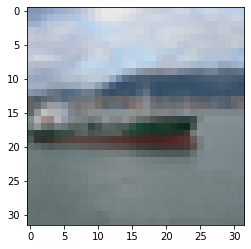

In [48]:
idx = np.random.randint(0,10000)
y = np.argmax(predicts[idx])
labels = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Predicted: ' + labels[y])
print("Actual: " + labels[(np.argmax(y_test[idx]))])
img = x_test[idx]
plt.imshow(img)

In [109]:
m